In [172]:
## knjižnice:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import arch

In [173]:
## podatki, ki so nam jih poslali:
podatki = pd.read_csv(os.path.join('C:/Users/Uporabnik/OneDrive/Namizje/SOLA/MAGISTERIJ/MATEMATIKA Z RACUNALNIKOM/GospodinjskiOdjemalci.csv'), sep=";")
# Malo boljši format:
podatki['DateTimeStartUTC'] = pd.to_datetime(podatki['DateTimeStartUTC'], format='%d.%m.%Y %H:%M')
podatki['DateTimeStartCET'] = pd.to_datetime(podatki['DateTimeStartCET'], format='%d.%m.%Y %H:%M')

podatki = podatki[['DateTimeStartUTC', 'Odjem ACT', 'Temperatura ACT', 'Temperatura FC', 'Sevanje ACT', 'Sevanje FC']]

podatki.set_index('DateTimeStartUTC', inplace=True)
podatki['Year'] = podatki.index.year
podatki['Month'] = podatki.index.month
podatki['Day'] = podatki.index.date
podatki['Time'] = podatki.index.time

podatki = podatki.asfreq('15T')

podatki['Odjem ACT'] = podatki['Odjem ACT'] * 1000000000 # da dobim MWh (bo lepše pri logaritmu tega stolpce v nadaljevanju)

podatki


,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day,Time
DateTimeStartUTC,,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:00:00
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:15:00
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:30:00
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:45:00
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01,00:00:00
...,...,...,...,...,...,...,...,...,...
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29,21:45:00
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29,22:00:00
2024-02-29 22:15:00,10796.70,6.50,7.300,0.0,0.0,2024,2,2024-02-29,22:15:00


In [174]:
sns.set(rc={'figure.figsize':(20, 6)}) 
plt.style.use('seaborn-white')

Text(0, 0.5, 'Odjem [MWh]')

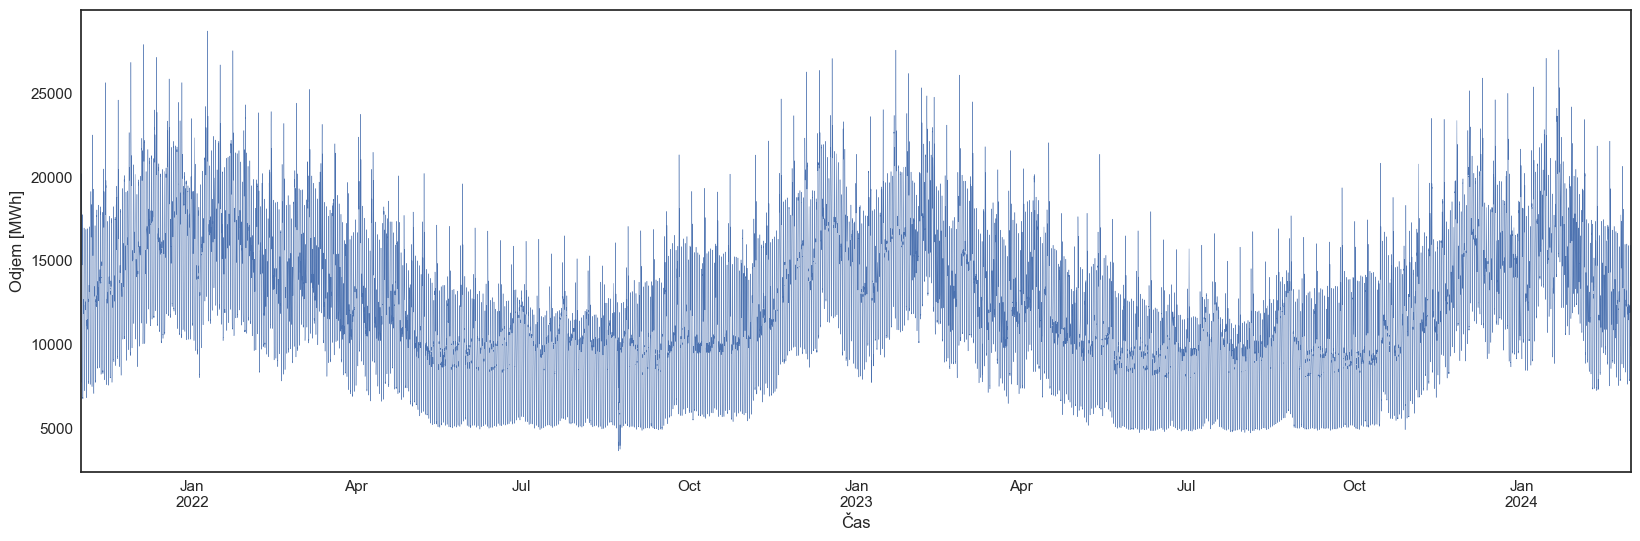

In [175]:
plt.style.use('seaborn-white')
podatki['Odjem ACT'].plot(linewidth=0.3)
# plt.title('Odjem električne energije gospodinjskih odjemalcev, 2021-2024', fontsize=20, weight='bold')
plt.xlabel('Čas')
plt.ylabel('Odjem [MWh]')

In [176]:
## Številki opis podatkov:
pd.DataFrame([('Odjem', podatki['Odjem ACT'].min(), podatki['Odjem ACT'].max(), podatki['Odjem ACT'].mean(), podatki['Odjem ACT'].median(), podatki['Odjem ACT'].std())],
                    columns=(' ', 'Min', 'Max', 'Povprečje', 'Mediana', 'sd' ))

,,Min,Max,Povprečje,Mediana,sd
0,Odjem,3629.32,28736.8,12240.501427,11708.45,4167.961058


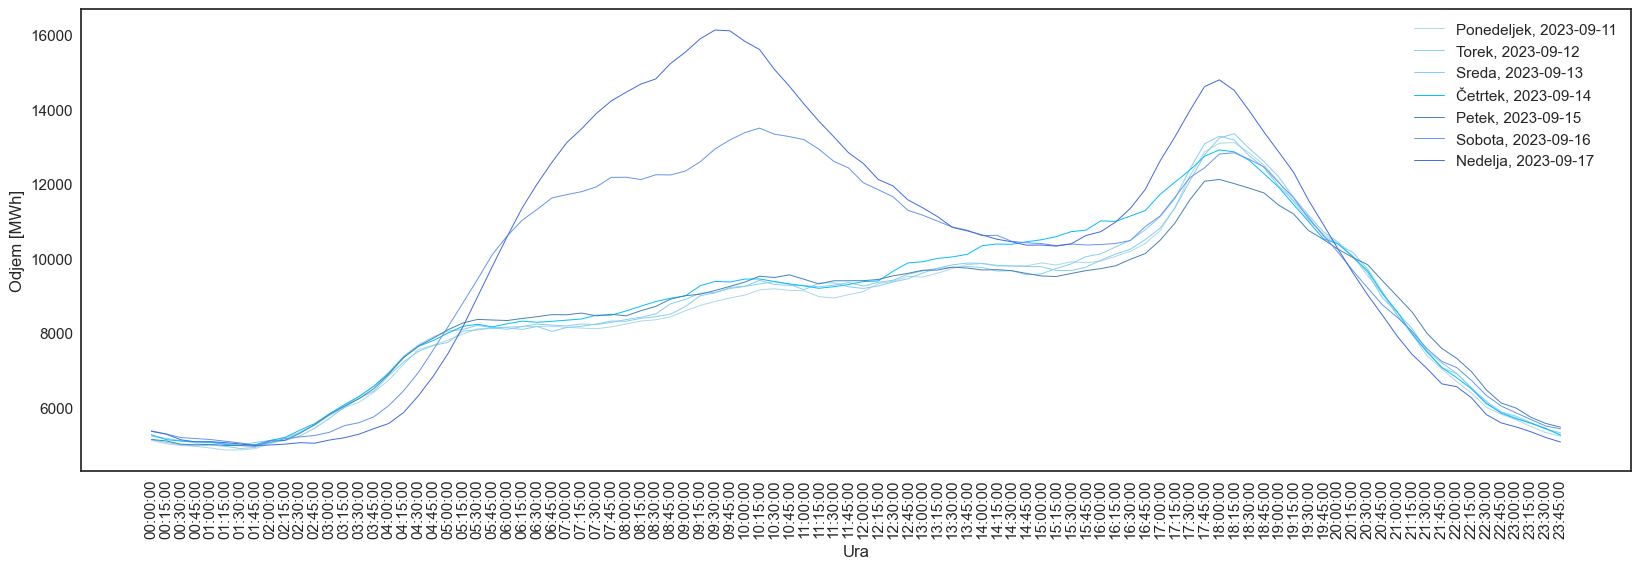

In [177]:
plt.xticks(rotation = 90)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-11', 'Odjem ACT'], label='Ponedeljek, 2023-09-11', color='lightblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-12', 'Odjem ACT'], label='Torek, 2023-09-12', color='skyblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-13', 'Odjem ACT'], label='Sreda, 2023-09-13', color='lightskyblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-14', 'Odjem ACT'], label='Četrtek, 2023-09-14', color='deepskyblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-15', 'Odjem ACT'], label='Petek, 2023-09-15', color='steelblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-16', 'Odjem ACT'], label='Sobota, 2023-09-16', color='cornflowerblue', linewidth=0.7)
plt.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-17', 'Odjem ACT'], label='Nedelja, 2023-09-17', color='royalblue', linewidth=0.7)
plt.xlabel('Ura')
plt.ylabel('Odjem [MWh]')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


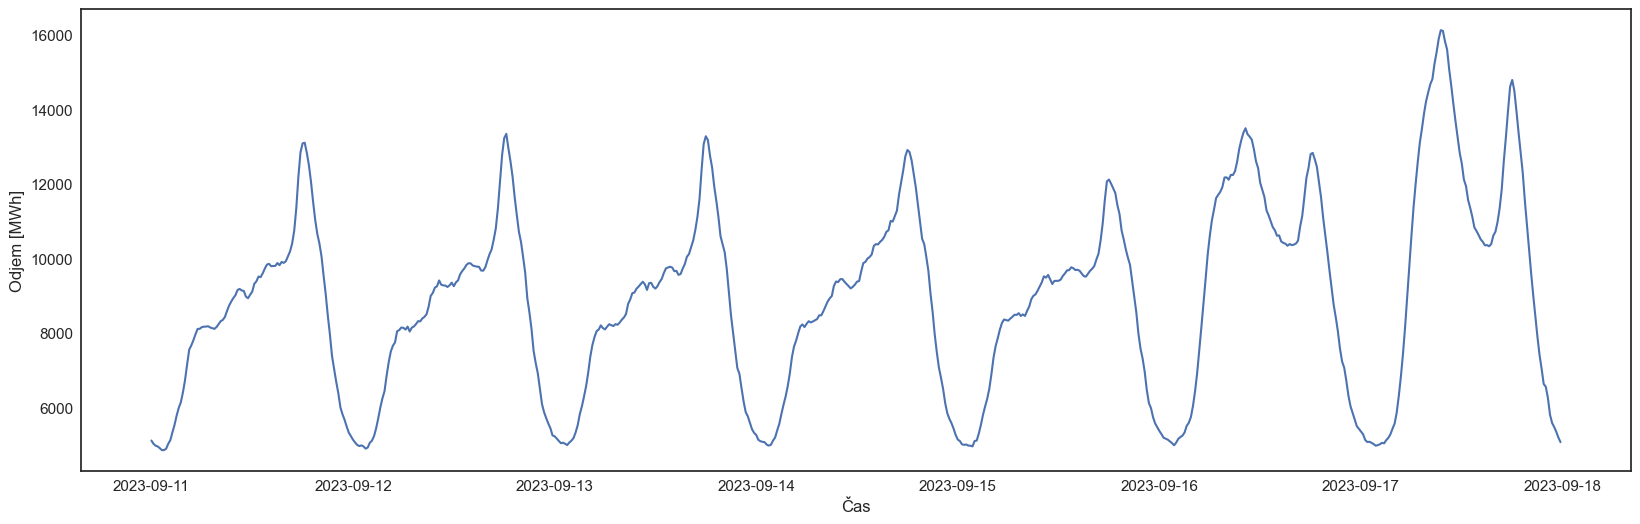

In [178]:
plt.plot(podatki.loc['2023-09-11':'2023-09-17', 'Odjem ACT'])
plt.xlabel('Čas')
plt.ylabel('Odjem [MWh]')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


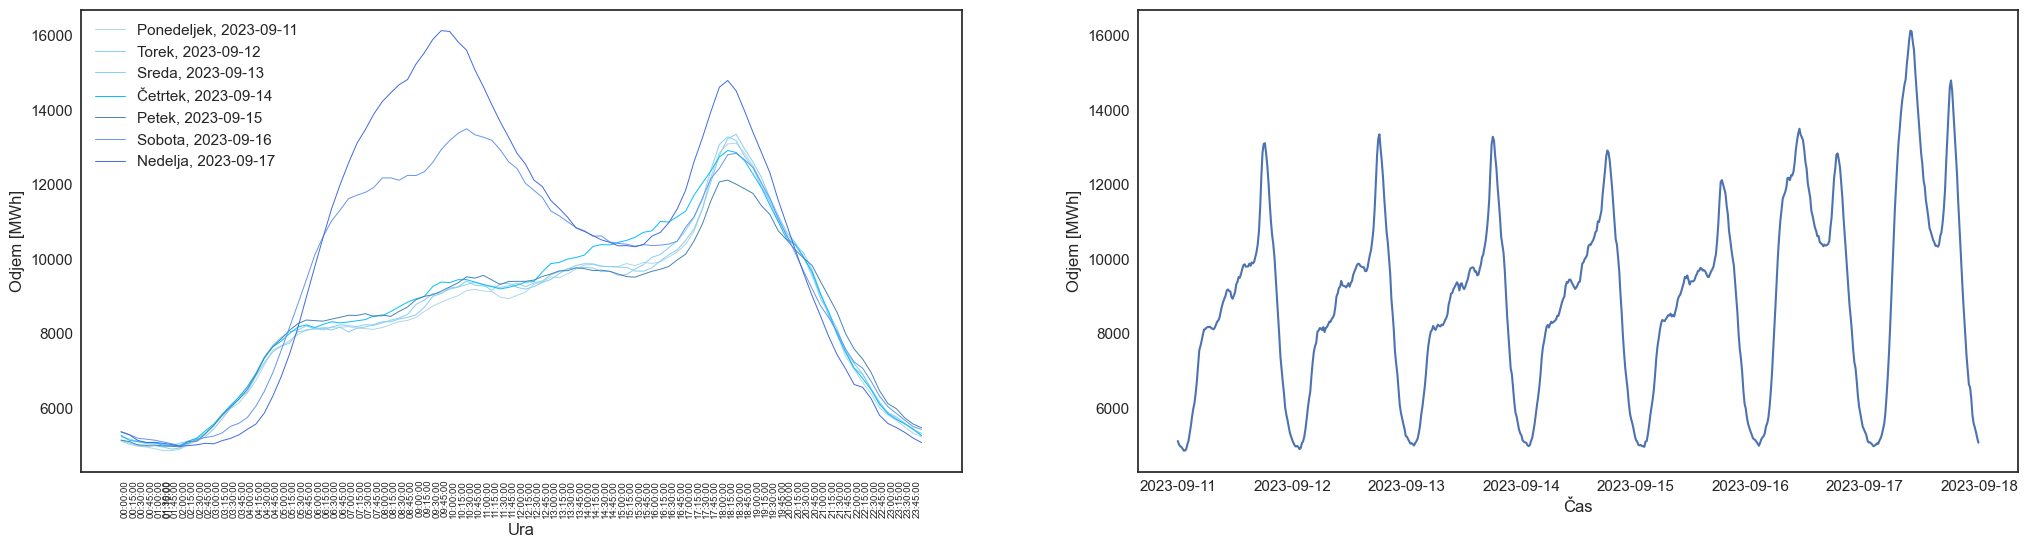

In [194]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(25, 6))

plt.setp(ax1.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-11', 'Odjem ACT'], label='Ponedeljek, 2023-09-11', color='lightblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-12', 'Odjem ACT'], label='Torek, 2023-09-12', color='skyblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-13', 'Odjem ACT'], label='Sreda, 2023-09-13', color='lightskyblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-14', 'Odjem ACT'], label='Četrtek, 2023-09-14', color='deepskyblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-15', 'Odjem ACT'], label='Petek, 2023-09-15', color='steelblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-16', 'Odjem ACT'], label='Sobota, 2023-09-16', color='cornflowerblue', linewidth=0.7)
ax1.plot(podatki.loc['2023-09-11', 'Time'].values.astype(str), podatki.loc['2023-09-17', 'Odjem ACT'], label='Nedelja, 2023-09-17', color='royalblue', linewidth=0.7)
ax1.tick_params(axis="x", labelsize=7)
ax1.set(xlabel = 'Ura', ylabel = 'Odjem [MWh]')
ax1.legend()

ax2.plot(podatki.loc['2023-09-11':'2023-09-17', 'Odjem ACT'])
ax2.set(xlabel = 'Čas', ylabel = 'Odjem [MWh]')
ax2.legend()

In [197]:
podatki['log return'] = np.log(podatki['Odjem ACT']/podatki['Odjem ACT'].shift(-1))
podatki = podatki.dropna()
podatki

,Odjem ACT,Temperatura ACT,Temperatura FC,Sevanje ACT,Sevanje FC,Year,Month,Day,Time,log return
DateTimeStartUTC,,,,,,,,,,
2021-10-31 23:00:00,9508.67,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:00:00,0.036444
2021-10-31 23:15:00,9168.37,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:15:00,0.034200
2021-10-31 23:30:00,8860.11,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:30:00,0.040203
2021-10-31 23:45:00,8510.97,3.60,5.300,0.0,0.0,2021,10,2021-10-31,23:45:00,0.021227
2021-11-01 00:00:00,8332.21,3.45,5.300,0.0,0.0,2021,11,2021-11-01,00:00:00,0.004812
...,...,...,...,...,...,...,...,...,...,...
2024-02-29 21:30:00,12529.80,6.85,7.650,0.0,0.0,2024,2,2024-02-29,21:30:00,0.042745
2024-02-29 21:45:00,12005.50,6.80,7.475,0.0,0.0,2024,2,2024-02-29,21:45:00,0.057346
2024-02-29 22:00:00,11336.40,6.65,7.300,0.0,0.0,2024,2,2024-02-29,22:00:00,0.048778


Text(0, 0.5, 'Log returns')

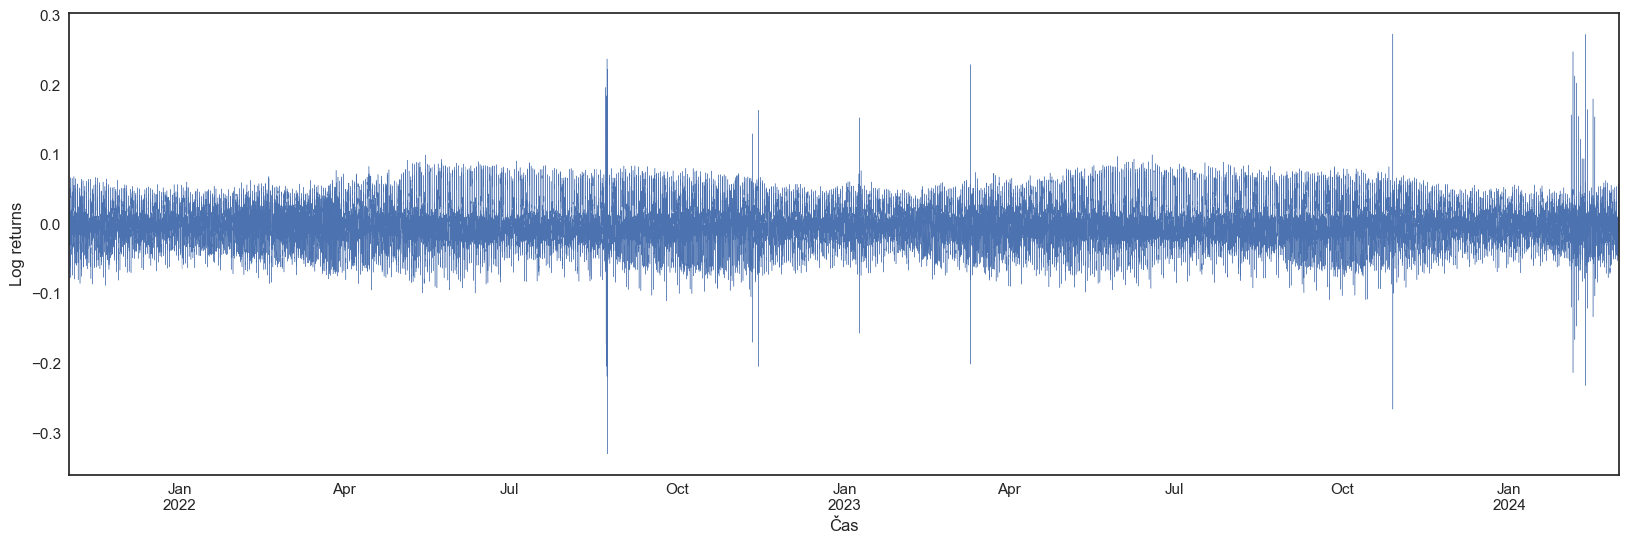

In [199]:
podatki['log return'].plot(linewidth=0.3)
plt.xlabel('Čas')
plt.ylabel('Log returns')
# to je ful bolj stacionarno

In [200]:
from arch.unitroot import *

def preveri_stacionarnost(ts):
    print(ADF(ts).summary())
    print('\n')
    print(KPSS(ts).summary())
    print('\n')
    print(PhillipsPerron(ts).summary())

In [201]:
preveri_stacionarnost(podatki['log return'])

# vsi testi povedo, da je časovna vrsta stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -83.893
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.001
P-value                         1.000
Lags                              133
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic                -58.607
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

In [210]:
def plot_acf_pach (time_series, n_lags):

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20, 6))

    tsaplots.plot_acf(time_series, lags=n_lags, ax=ax1)
    ax1.set(xlabel = 'Odlogi', ylabel = 'ACF', title = 'Vzorčna avtokorelacijska funkcija')

    tsaplots.plot_pacf(time_series, lags=n_lags, ax=ax2)
    ax2.set(xlabel = 'Odlogi', ylabel = 'PACF', title = 'Vzorčna parcialna avtokorelacijska funkcija')

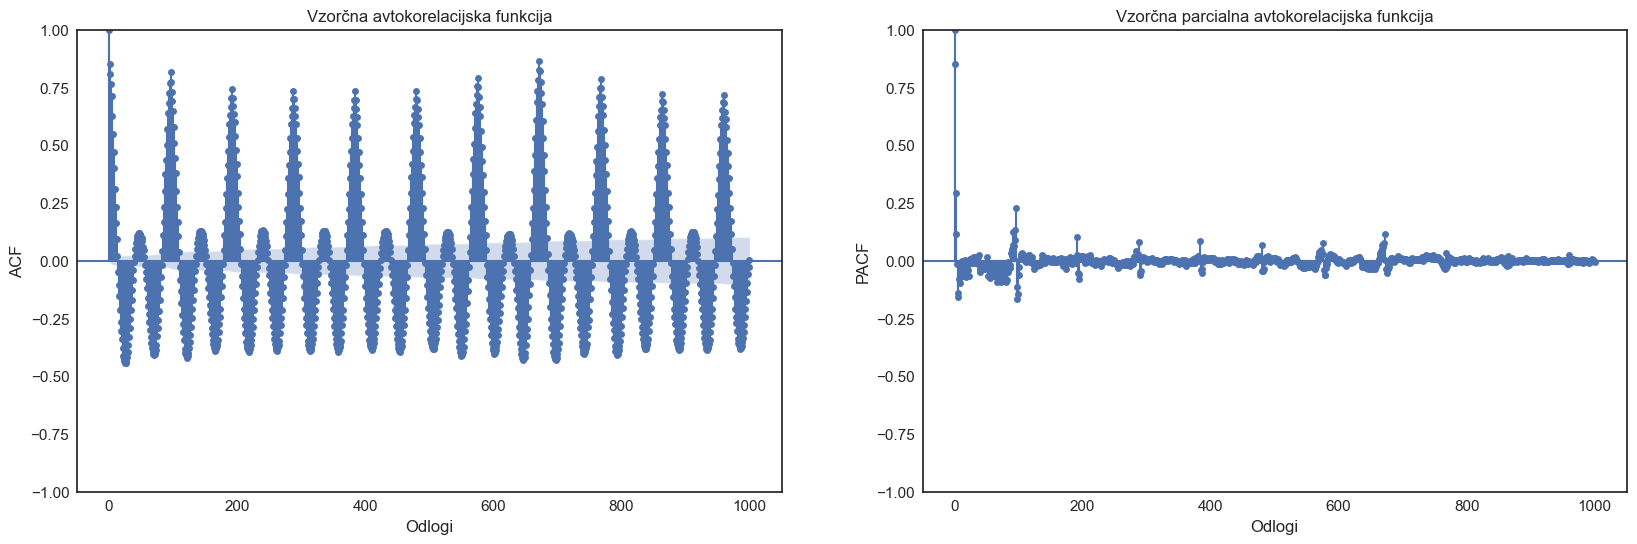

In [211]:
plot_acf_pach(podatki['log return'], 1000)

In [212]:
ts_diff = podatki['log return'].diff(periods = 96).dropna()

Text(0, 0.5, '')

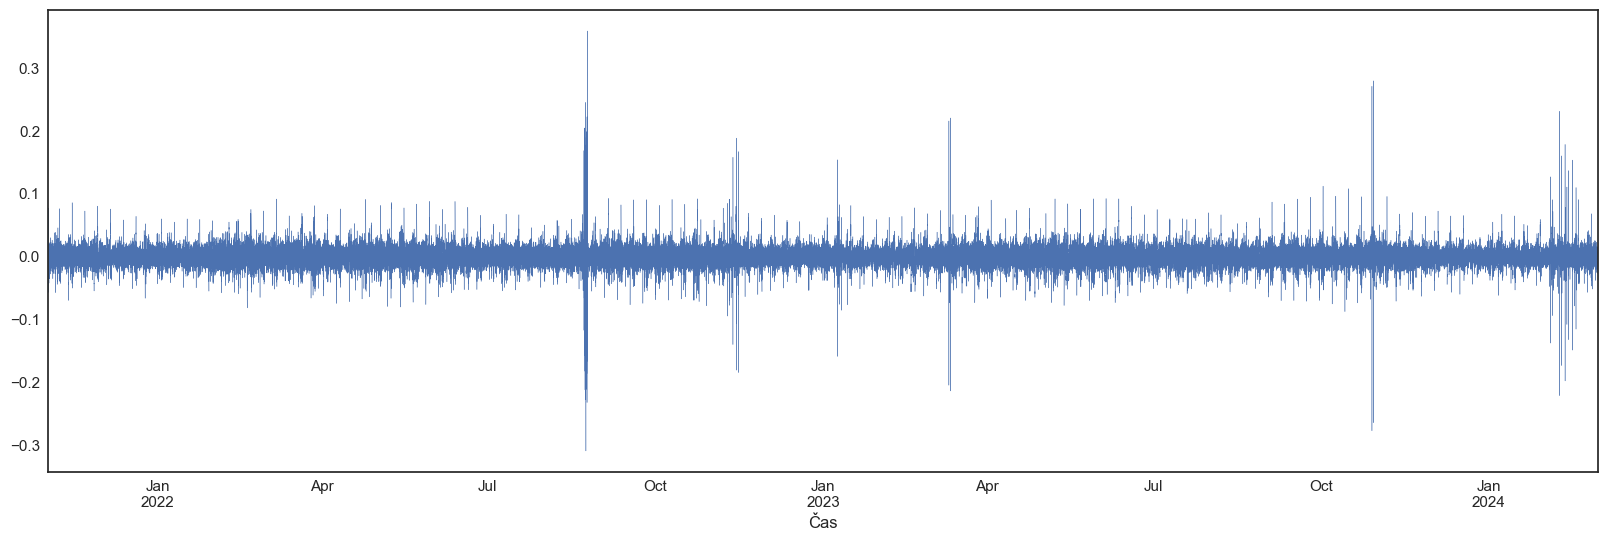

In [213]:
ts_diff.plot(linewidth=0.3) 
plt.xlabel('Čas')
plt.ylabel('')

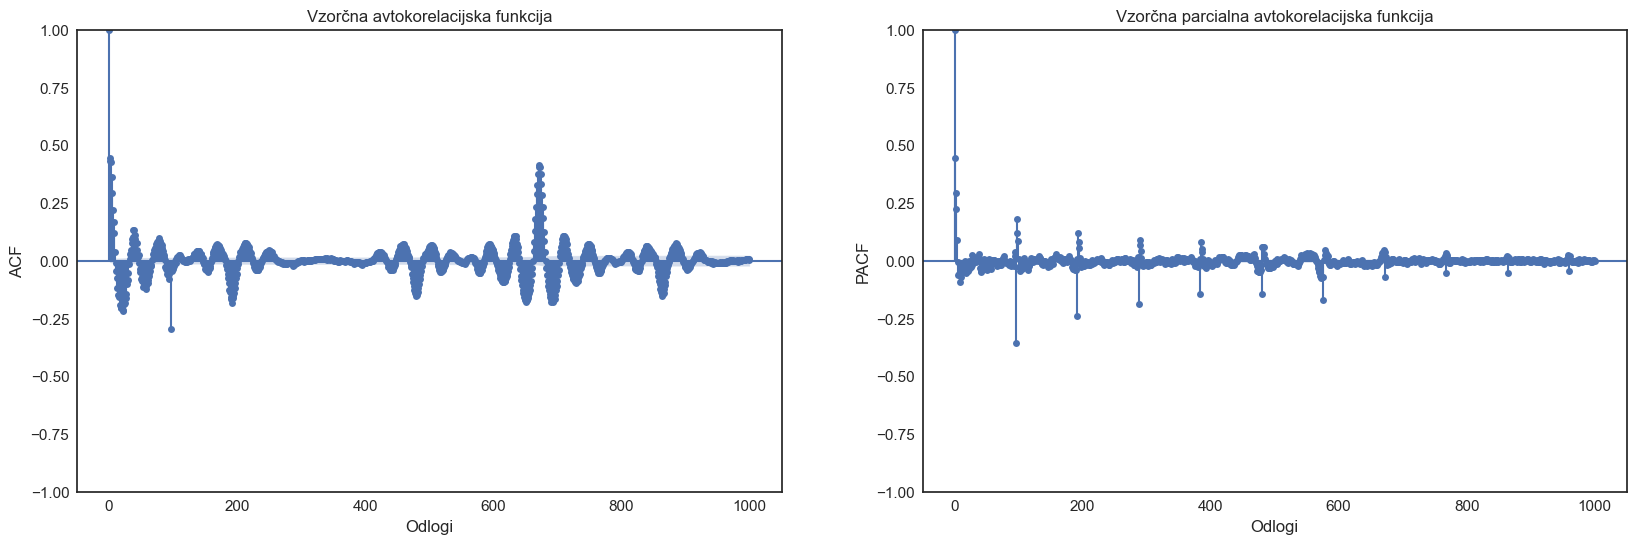

In [214]:
plot_acf_pach(ts_diff, 1000)

In [215]:
ts_diff_2 = ts_diff.diff().dropna()

Text(0, 0.5, '')

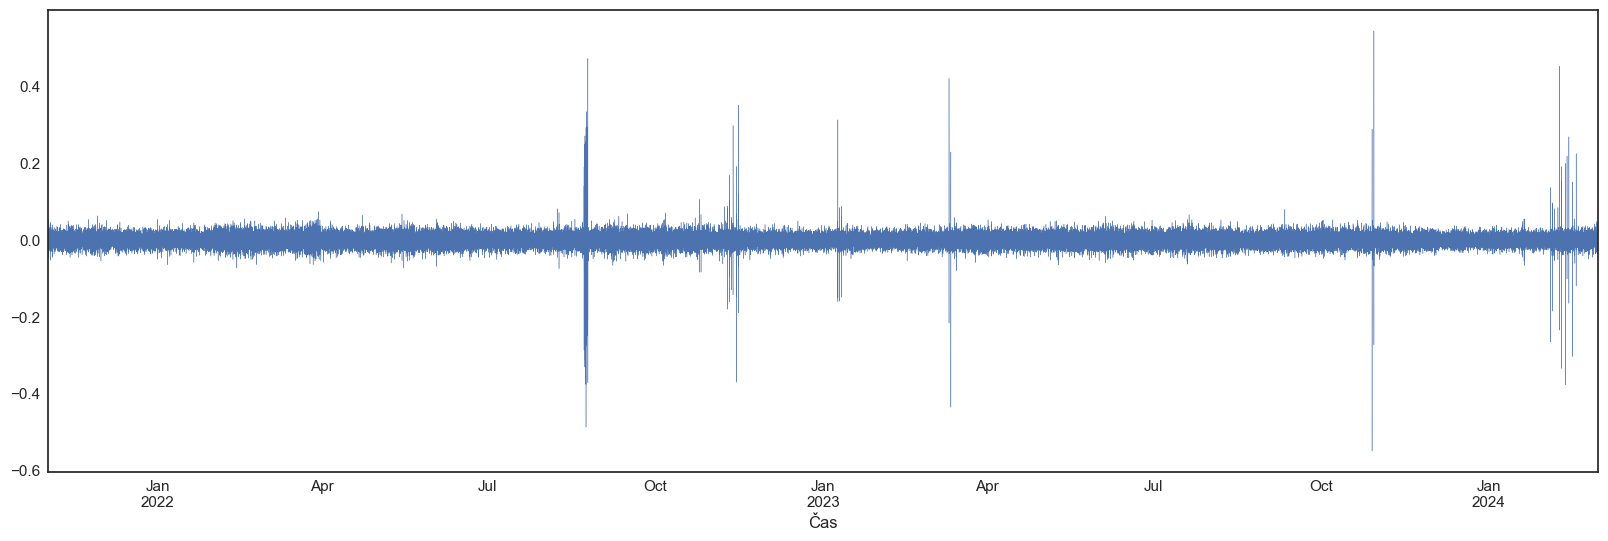

In [216]:
ts_diff_2.plot(linewidth=0.3) 
plt.xlabel('Čas')
plt.ylabel('')

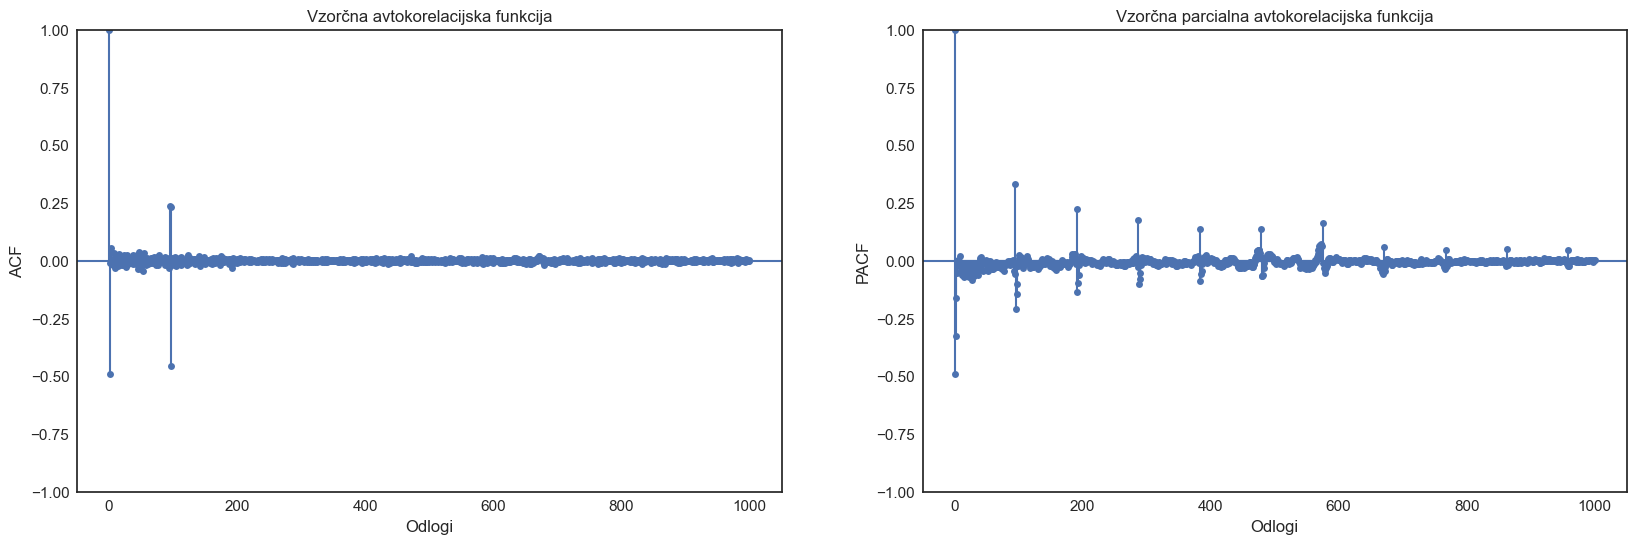

In [217]:
plot_acf_pach(ts_diff_2, 1000)

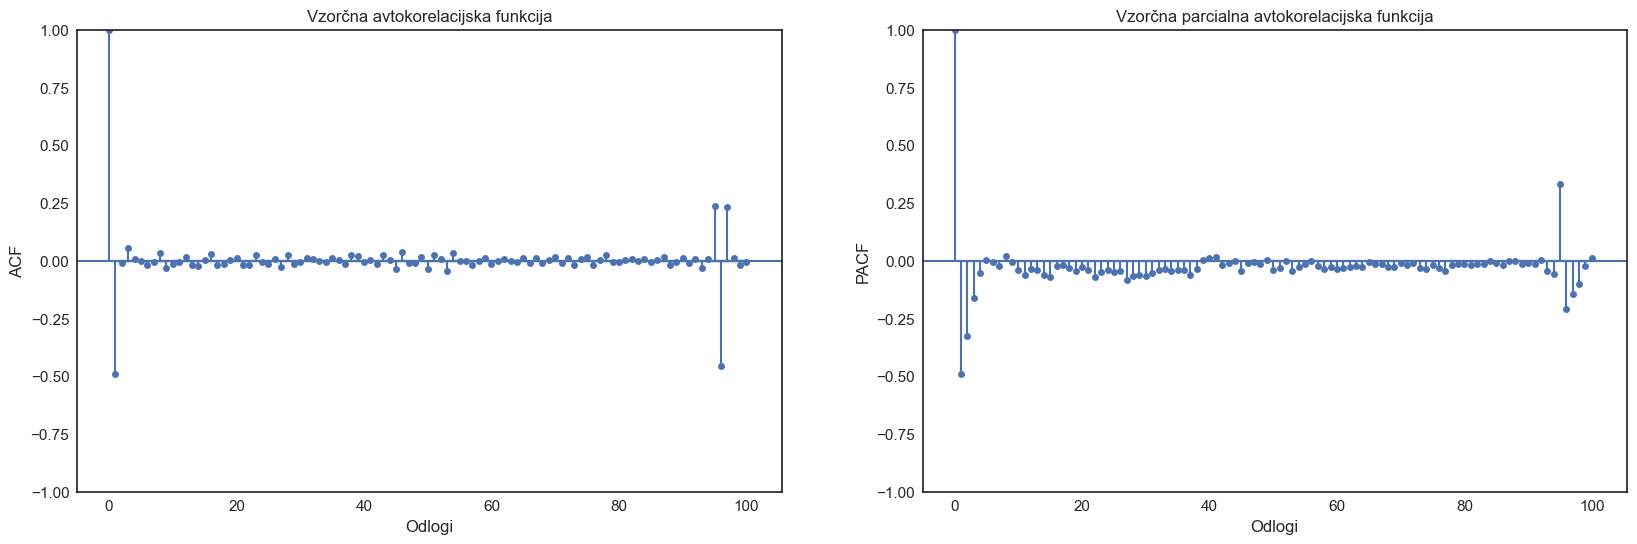

In [218]:
plot_acf_pach(ts_diff_2, 100)

# q je 1 ali pa 95
# p je 1, 2, 3 ali 95

In [28]:
preveri_stacionarnost(ts_diff_2)

# vsi testi povedo, da je stacionarna

   Augmented Dickey-Fuller Results   
Test Statistic                -64.756
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


    KPSS Stationarity Test Results   
Test Statistic                  0.002
P-value                         1.000
Lags                              243
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


     Phillips-Perron Test (Z-tau)    
Test Statistic              -1501.246
P-value                         0.000
Lags                               65
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
N

In [220]:
# TRAIN na 75 % (od 2021-11-01 23:00:00 do 2023-08-04 23:45:00)
# TEST na 25 %

start = 0
end = 61540

# train data:
df = podatki[(start+96):(end+96)]

train_data_log = df['log return']
train_data_diff_96 = ts_diff[(start):(end)] # !!
train_exog = df[['Temperatura FC', 'Sevanje FC']]

# test data:
df_test = podatki[(end+96):(end+96+96)]

day = '2023-08-05'
next_day = '2023-08-06'

test_data_log = df_test['log return']
test_data_diff_96 = ts_diff[end:(end+96)] # !!
test_exog = df_test[['Temperatura FC', 'Sevanje FC']]

In [92]:
# delala bom na ts_diff (torej na 1x sezonsko diferenciranih) --> d = 1 
# na koncu bom oddiferencirala in naredila inverz od log returns da pridem nazaj na originalno skalo

In [56]:
def RMSE_MAPE (podatki_OG, napoved):
    '''Funkcija RMSE_MAPE izračuna napaki RMSE in MAPE. Vrne seznam oblike [RMSE, MAPE]'''
    errors = podatki_OG - napoved
    mse = np.mean(errors**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(errors / podatki_OG)) * 100
    return [rmse, mape]

def napoved_na_OG_skala (podatki, napoved, dan, naslednji_dan):
    '''Najprej dediferenciramo in nato naredimo inverz log returnov.'''
    napoved_ = napoved + podatki['log return'].shift(-96)[dan]
    
    start = dan + ' 00:00:00'
    end = naslednji_dan + ' 00:00:00'

    return(np.exp(napoved_ + np.log(podatki.loc[start:end, 'Odjem ACT'].shift(-1)[dan])))

def izrisi_graf_napovedi (podatki, napoved, naslov):
    '''Funkcija izrisi_graf_napovedi izriše graf napovedi'''
    plt.style.use('seaborn-whitegrid')
    plt.plot(podatki, label='Dejanski podatki', color='gray')
    plt.plot(napoved, label='Napovedani podatki', color='orangered')
    plt.title(naslov, fontsize=15)
    plt.xlabel('Čas')
    plt.ylabel('Odjem [kWh]')
    plt.legend()
    plt.show()

In [221]:
def ARIMA_no_exog(p, d, q, train):
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q))
    results = model.fit()
    return results

def ARIMA_exog(p, d, q, train, exog):
    model = sm.tsa.statespace.SARIMAX(train, order=(p, d, q), exog = exog)
    results = model.fit()
    return results

def GARCH (residuali, p, q):
    model = arch.arch_model(residuali, mean='Zero', vol='Garch', p=p, q=q)
    results = model.fit()
    return results

def forecast_no_exog (results, steps):
    return results.forecast(steps)

def forecast_exog (results, steps, exog):
    return results.forecast(steps=steps, exog=exog)

In [10]:
results_1 = ARIMA_exog(1, 1, 0, train_data_diff_96, train_exog)
# 13.2s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
forecast_1 = forecast_exog(results_1, 96, test_exog)
# na OG skalo:
forecast_OG_1 = napoved_na_OG_skala(podatki, forecast_1, day, next_day)

errors_1 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_1)
errors_1

[157.0568199526522, 1.1051986523984216]

In [11]:
results_2 = ARIMA_exog(0, 1, 1, train_data_diff_96, train_exog)
# 19.4s

In [35]:
forecast_2 = forecast_exog(results_2, 96, test_exog)
# na OG skalo:
forecast_OG_2 = napoved_na_OG_skala(podatki, forecast_2, day, next_day)

errors_2 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_2)
errors_2

[156.45647377845617, 1.1021269871265158]

In [12]:
results_3 = ARIMA_exog(1, 1, 1, train_data_diff_96, train_exog)
# 42.0s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [36]:
forecast_3 = forecast_exog(results_3, 96, test_exog)
# na OG skalo:
forecast_OG_3 = napoved_na_OG_skala(podatki, forecast_3, day, next_day)

errors_3 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_3)
errors_3

[156.47263873589245, 1.1022190066927853]

In [13]:
results_4 = ARIMA_exog(2, 1, 2, train_data_diff_96, train_exog)
# 25.6s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [37]:
forecast_4 = forecast_exog(results_4, 96, test_exog)
# na OG skalo:
forecast_OG_4 = napoved_na_OG_skala(podatki, forecast_4, day, next_day)

errors_4 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_4)
errors_4

[156.98487656580875, 1.1048979316203285]

In [14]:
results_5 = ARIMA_exog(3, 1, 2, train_data_diff_96, train_exog)
# 26.4s

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [38]:
forecast_5 = forecast_exog(results_5, 96, test_exog)
# na OG skalo:
forecast_OG_5 = napoved_na_OG_skala(podatki, forecast_5, day, next_day)

errors_5 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_5)
errors_5

[156.923462520095, 1.1046522982332048]

In [15]:
results_6 = ARIMA_exog(4, 1, 3, train_data_diff_96, train_exog)
# 3m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [39]:
forecast_6 = forecast_exog(results_6, 96, test_exog)
# na OG skalo:
forecast_OG_6 = napoved_na_OG_skala(podatki, forecast_6, day, next_day)

errors_6 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_6)
errors_6

[258.43943099736185, 2.059322726065242]

In [16]:
results_7 = ARIMA_exog(5, 1, 4, train_data_diff_96, train_exog)
# 2m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [40]:
forecast_7 = forecast_exog(results_7, 96, test_exog)
# na OG skalo:
forecast_OG_7 = napoved_na_OG_skala(podatki, forecast_7, day, next_day)

errors_7 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_7)
errors_7

[154.22758429144432, 1.0958646270979264]

In [17]:
results_8 = ARIMA_exog(5, 1, 5, train_data_diff_96, train_exog)
# 2m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [41]:
forecast_8 = forecast_exog(results_8, 96, test_exog)
# na OG skalo:
forecast_OG_8 = napoved_na_OG_skala(podatki, forecast_8, day, next_day)

errors_8 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_8)
errors_8

[153.92291782014985, 1.0951634259416103]

In [18]:
results_9 = ARIMA_exog(4, 1, 5, train_data_diff_96, train_exog)
# 1m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
forecast_9 = forecast_exog(results_9, 96, test_exog)
# na OG skalo:
forecast_OG_9 = napoved_na_OG_skala(podatki, forecast_9, day, next_day)

errors_9 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_9)
errors_9

[156.83390557235174, 1.1041397908825865]

In [19]:
results_10 = ARIMA_exog(6, 1, 5, train_data_diff_96, train_exog)
# 4m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [43]:
forecast_10 = forecast_exog(results_10, 96, test_exog)
# na OG skalo:
forecast_OG_10 = napoved_na_OG_skala(podatki, forecast_10, day, next_day)

errors_10 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_10)
errors_10

[153.91687726258925, 1.0952189746672252]

In [20]:
results_11 = ARIMA_exog(6, 1, 6, train_data_diff_96, train_exog) 
# 4m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [44]:
forecast_11 = forecast_exog(results_11, 96, test_exog)
# na OG skalo:
forecast_OG_11 = napoved_na_OG_skala(podatki, forecast_11, day, next_day)

errors_11 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_11)
errors_11

[153.97906945247192, 1.0959353955469662]

In [21]:
results_12 = ARIMA_exog(5, 1, 6, train_data_diff_96, train_exog) 
# 3m

c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Uporabnik\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [45]:
forecast_12 = forecast_exog(results_12, 96, test_exog)
# na OG skalo:
forecast_OG_12 = napoved_na_OG_skala(podatki, forecast_12, day, next_day)

errors_12 = RMSE_MAPE (podatki.loc[day, 'Odjem ACT'], forecast_OG_12)
errors_12

[154.02346024845522, 1.0959107330636153]

In [49]:
pd.DataFrame([
    ['SARIMA(1,1,0)(0,1,0)[96]', results_1.aic, errors_1[0], errors_1[1]], 
    ['SARIMA(0,1,1)(0,1,0)[96]', results_2.aic, errors_2[0], errors_2[1]], 
    ['SARIMA(1,1,1)(0,1,0)[96]', results_3.aic, errors_3[0], errors_3[1]], 
    ['SARIMA(2,1,1)(0,1,0)[96]', results_4.aic, errors_4[0], errors_4[1]], 
    ['SARIMA(3,1,2)(0,1,0)[96]', results_5.aic, errors_5[0], errors_5[1]],
    ['SARIMA(4,1,3)(0,1,0)[96]', results_6.aic, errors_6[0], errors_6[1]], 
    ['SARIMA(5,1,4)(0,1,0)[96]', results_7.aic, errors_7[0], errors_7[1]], 
    ['SARIMA(5,1,5)(0,1,0)[96]', results_8.aic, errors_8[0], errors_8[1]], 
    ['SARIMA(4,1,5)(0,1,0)[96]', results_9.aic, errors_9[0], errors_9[1]], 
    ['SARIMA(6,1,5)(0,1,0)[96]', results_10.aic, errors_11[0], errors_10[1]], 
    ['SARIMA(6,1,6)(0,1,0)[96]', results_11.aic, errors_11[0], errors_11[1]], 
    ['SARIMA(5,1,6)(0,1,0)[96]', results_12.aic, errors_11[0], errors_12[1]]
],
columns=('Model', 'AIC', 'RMSE', 'MAPE'))

# Po AIC: najboljši je SARIMA(4,1,5) --> results_9
# Po RMSE in MAPE: sarima(5,1,5) --> results_8

,Model,AIC,RMSE,MAPE
0,"SARIMA(1,1,0)(0,1,0)[96]",-338588.046330,157.056820,1.105199
1,"SARIMA(0,1,1)(0,1,0)[96]",-346718.519174,156.456474,1.102127
2,"SARIMA(1,1,1)(0,1,0)[96]",-346768.583304,156.472639,1.102219
3,"SARIMA(2,1,1)(0,1,0)[96]",-347555.506685,156.984877,1.104898
4,"SARIMA(3,1,2)(0,1,0)[96]",-347573.393767,156.923463,1.104652
5,"SARIMA(4,1,3)(0,1,0)[96]",-278981.697958,258.439431,2.059323
6,"SARIMA(5,1,4)(0,1,0)[96]",-345287.412681,154.227584,1.095865
7,"SARIMA(5,1,5)(0,1,0)[96]",-345310.104621,153.922918,1.095163
8,"SARIMA(4,1,5)(0,1,0)[96]",-347619.304177,156.833906,1.104140
9,"SARIMA(6,1,5)(0,1,0)[96]",-345325.841533,153.979069,1.095219


In [55]:
import warnings
warnings.warn = lambda *a, **kw: False

pd.DataFrame([
    ['SARIMA(4,1,5)(0,1,0)[96]-GARCH(p,q)', 
     results_9.aic,
     GARCH(results_9.resid, 1, 1).aic,
     GARCH(results_9.resid, 1, 2).aic,
     GARCH(results_9.resid, 2, 1).aic,
     GARCH(results_9.resid, 2, 2).aic,
     GARCH(results_9.resid, 1, 3).aic,
     GARCH(results_9.resid, 3, 1).aic
     ], 
],
columns=('AIC', '(0, 0)', '(1, 1)', '(1, 2)', '(2, 1)', '(2, 2)', '(1, 3)', '(3, 1)'))

Iteration:      1,   Func. Count:      4,   Neg. LLF: -182880.2239040917
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -182880.22383275238
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: 33458700898.928905
Iteration:      2,   Func. Count:     12,   Neg. LLF: -183032.1089654104
Optimization terminated successfully    (Exit mode 0)
            Current function value: -183032.10895629268
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 2
Iteration:      1,   Func. Count:      5,   Neg. LLF: -182721.28834071316
Optimization terminated successfully    (Exit mode 0)
            Current function value: -182721.28836649185
            Iterations: 5
            Function evaluations: 5
            Gradient evaluations: 1
Iteration:      1,   Func. Count:      6,   Neg. LLF: -182926.83652269363
Optimizat

,AIC,"(0, 0)","(1, 1)","(1, 2)","(2, 1)","(2, 2)","(1, 3)","(3, 1)"
0,"SARIMA(4,1,5)(0,1,0)[96]-GARCH(p,q)",-347619.304177,-365754.447666,-366056.217913,-365434.576733,-365843.67319,-366134.33453,-365252.576424


In [ ]:
def SARIMA_GARCH_forecast(podatki, train_data, train_exog, test_data, test_exog, day, next_day):
    results = ARIMA_exog(4, 1, 5, train_data, train_exog)
    forecast = forecast_exog(results, 96, test_exog)

    results_GARCH = GARCH(results.resid, 1, 3)
    forecastGARCH = results_GARCH.forecast(horizon=96)
    forecast_ = forecast.mean() + forecastGARCH.variance.values[-1, :]
    forecastDf = pd.DataFrame(forecast_, index=forecast.index, columns=['Forecast'])
    forecast_OG = napoved_na_OG_skala(podatki, forecastDf['Forecast'], day, next_day)

    return forecast_OG

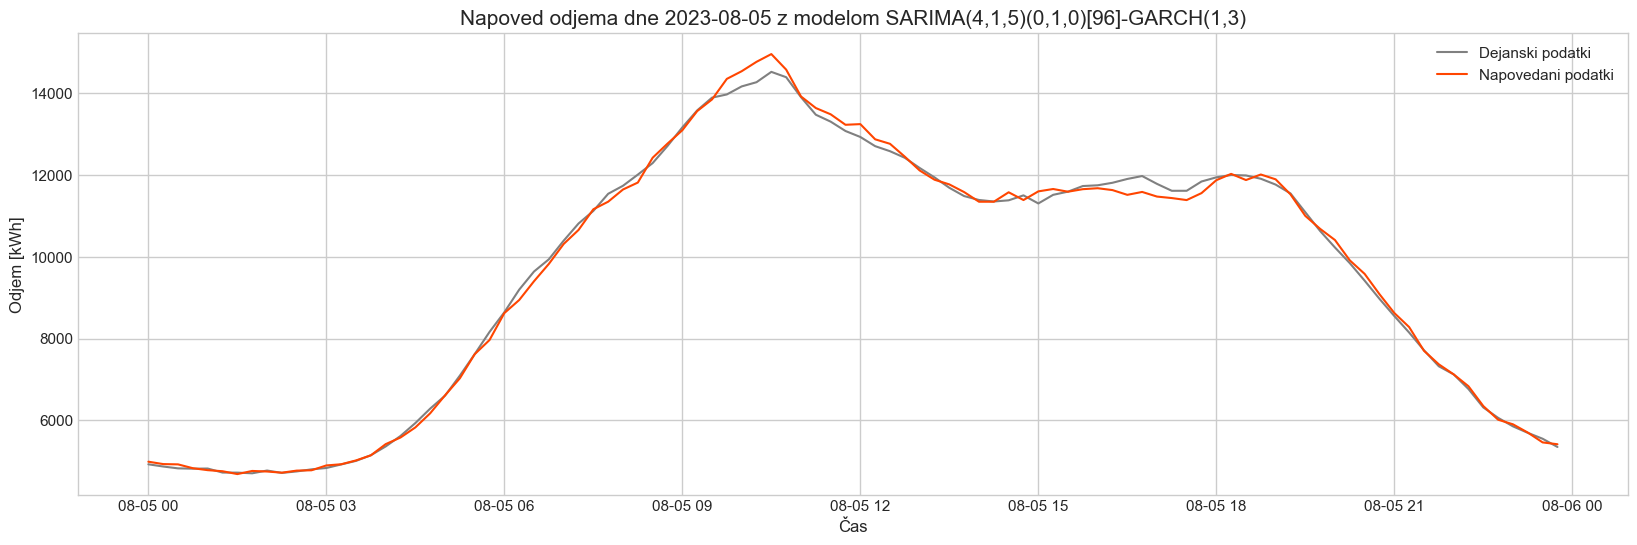

In [61]:
forecast_AG_1 = SARIMA_GARCH_forecast(podatki, train_data_diff_96, train_exog, test_data_diff_96, test_exog, day, next_day)    
izrisi_graf_napovedi(podatki.loc[day, 'Odjem ACT'], forecast_AG_1, 'Napoved odjema dne 2023-08-05 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')

Iteration:      1,   Func. Count:      6,   Neg. LLF: -221174.10387081993
Optimization terminated successfully    (Exit mode 0)
            Current function value: -221174.10393972343
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


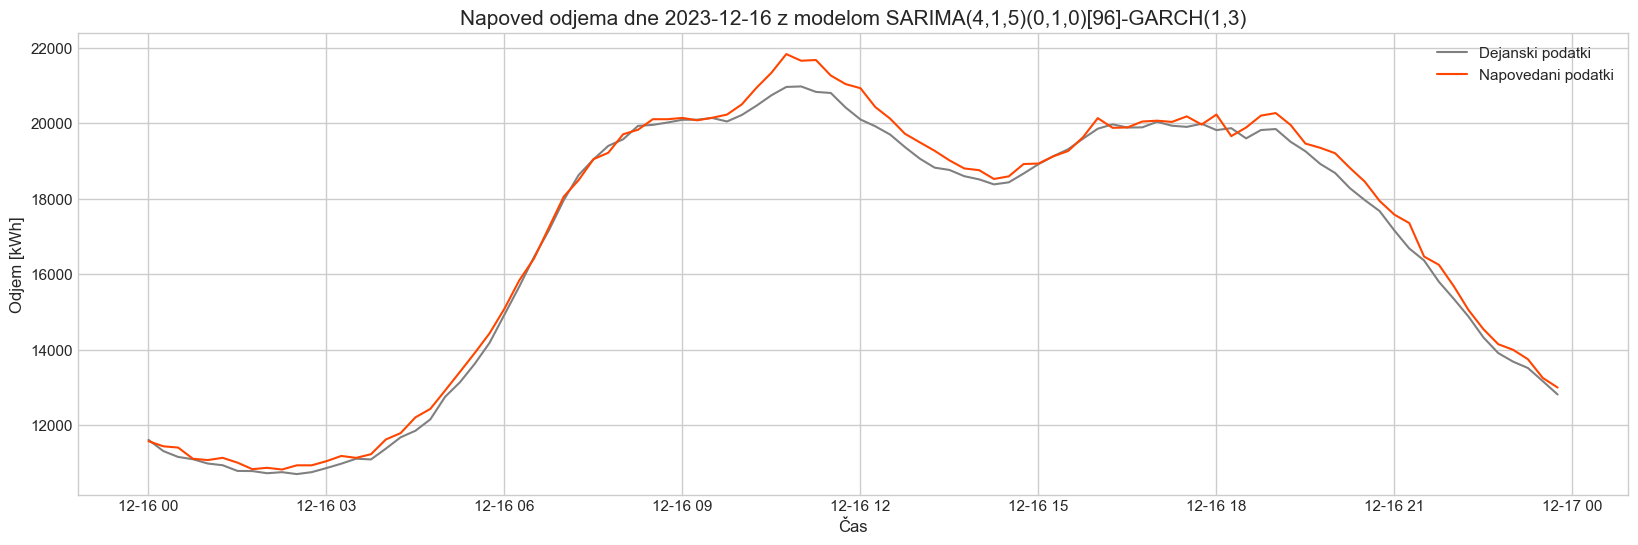

In [85]:
train_data_diff_96_2 = ts_diff['2021-11-02':'2023-12-15'] 
train_exog_2 = podatki.loc['2021-11-02':'2023-12-15', ['Temperatura FC', 'Sevanje FC']]
day_2 = '2023-12-16'
next_day_2 = '2023-12-17'
test_data_diff_96_2 = ts_diff[day_2] 
test_exog_2 = podatki.loc[day_2, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_2 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_2, train_exog_2, test_data_diff_96_2, test_exog_2, day_2, next_day_2)    
izrisi_graf_napovedi(podatki.loc[day_2, 'Odjem ACT'], forecast_AG_2, 'Napoved odjema dne 2023-12-16 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')

Iteration:      1,   Func. Count:      6,   Neg. LLF: -238136.25654619688
Optimization terminated successfully    (Exit mode 0)
            Current function value: -238136.25662460565
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


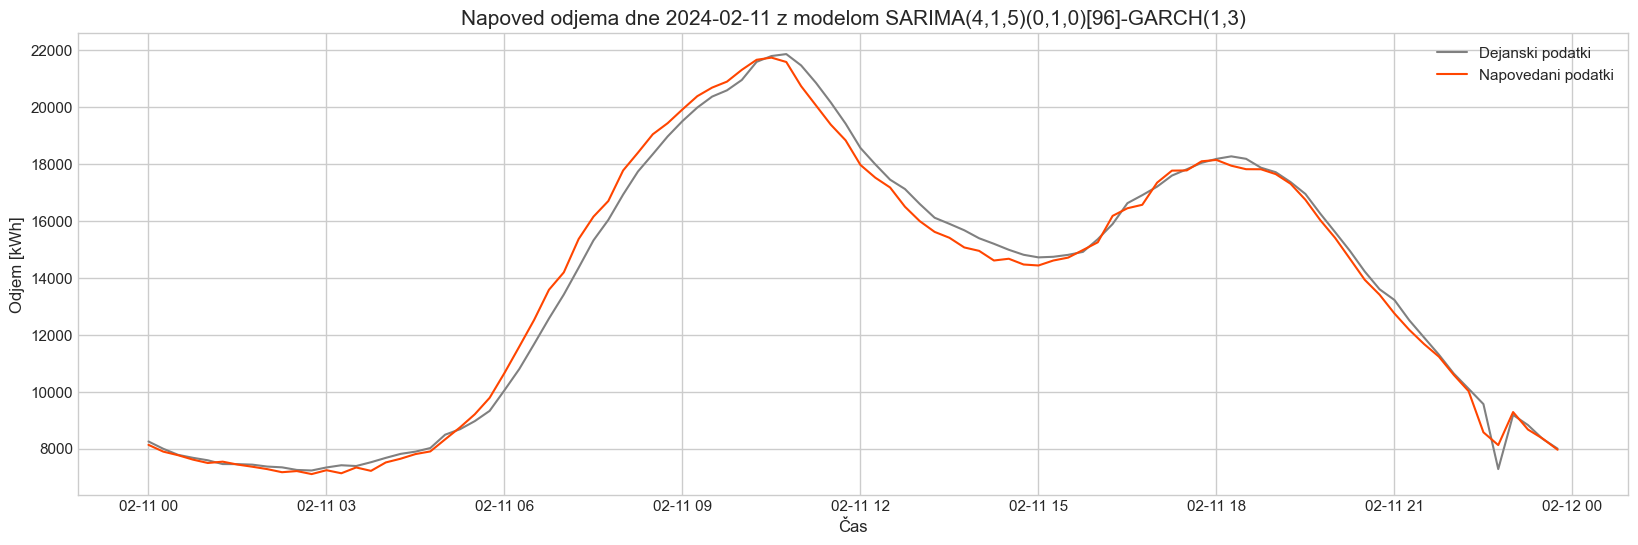

In [86]:
train_data_diff_96_3 = ts_diff['2021-11-02':'2024-02-10'] 
train_exog_3 = podatki.loc['2021-11-02':'2024-02-10', ['Temperatura FC', 'Sevanje FC']]
day_3 = '2024-02-11'
next_day_3 = '2024-02-12'
test_data_diff_96_3 = ts_diff[day_3] 
test_exog_3 = podatki.loc[day_3, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_3 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_3, train_exog_3, test_data_diff_96_3, test_exog_3, day_3, next_day_3)    
izrisi_graf_napovedi(podatki.loc[day_3, 'Odjem ACT'], forecast_AG_3, 'Napoved odjema dne 2024-02-11 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')

Iteration:      1,   Func. Count:      6,   Neg. LLF: -238272.4970987809
Optimization terminated successfully    (Exit mode 0)
            Current function value: -238272.49717485814
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


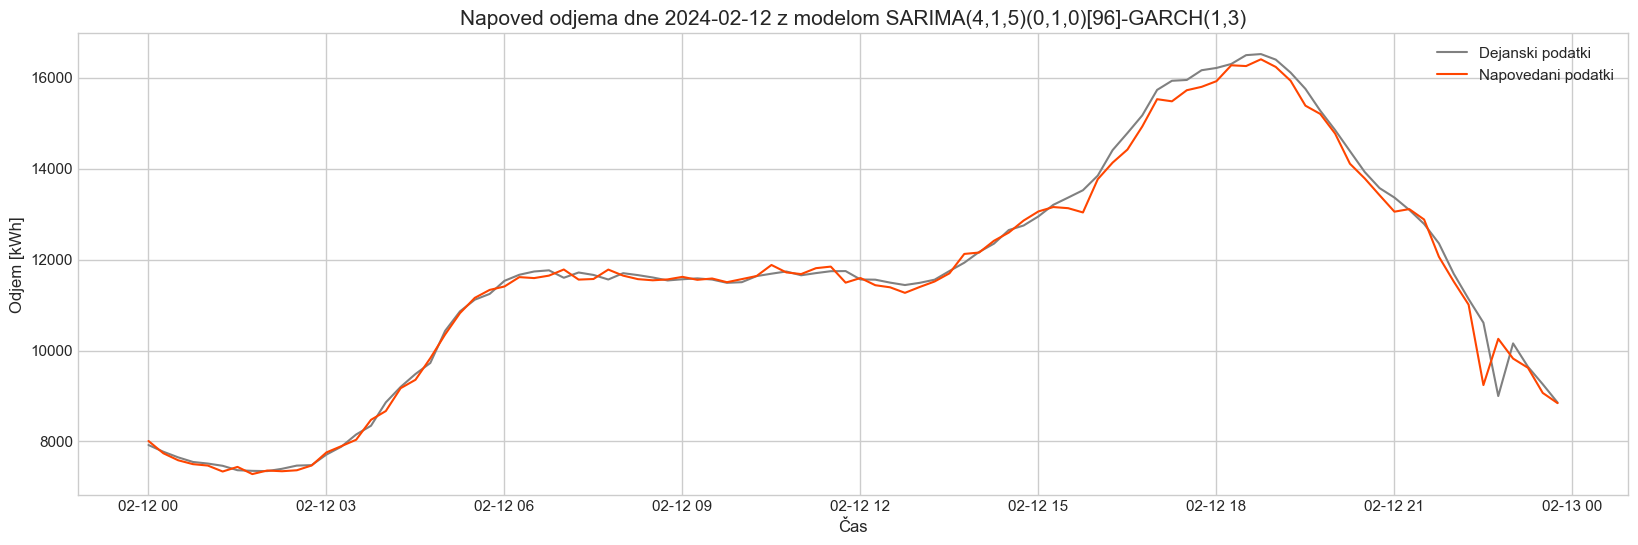

In [87]:
train_data_diff_96_4 = ts_diff['2021-11-02':'2024-02-11'] 
train_exog_4 = podatki.loc['2021-11-02':'2024-02-11', ['Temperatura FC', 'Sevanje FC']]
day_4 = '2024-02-12'
next_day_4 = '2024-02-13'
test_data_diff_96_4 = ts_diff[day_4] 
test_exog_4 = podatki.loc[day_4, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_4 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_4, train_exog_4, test_data_diff_96_4, test_exog_4, day_4, next_day_4)    
izrisi_graf_napovedi(podatki.loc[day_4, 'Odjem ACT'], forecast_AG_4, 'Napoved odjema dne 2024-02-12 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')

Iteration:      1,   Func. Count:      6,   Neg. LLF: -157149.2344721602
Optimization terminated successfully    (Exit mode 0)
            Current function value: -157149.23456257922
            Iterations: 5
            Function evaluations: 6
            Gradient evaluations: 1


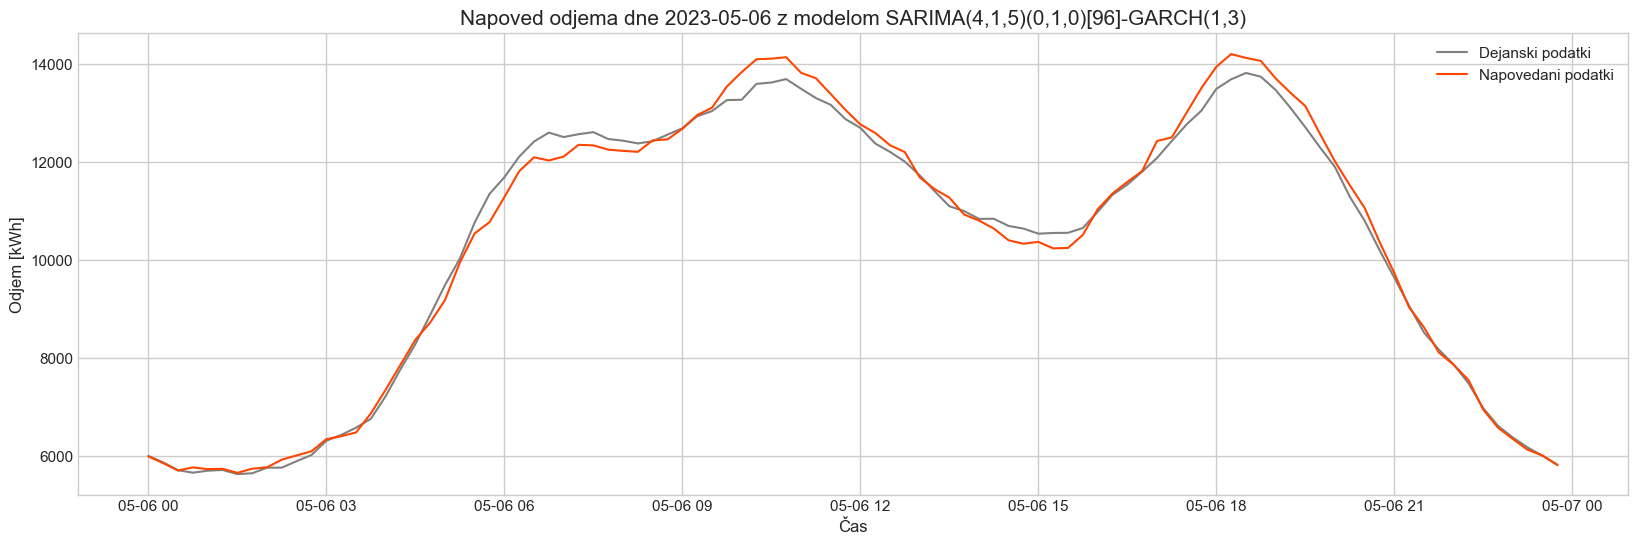

In [88]:
train_data_diff_96_5 = ts_diff['2021-11-02':'2023-05-05'] 
train_exog_5 = podatki.loc['2021-11-02':'2023-05-05', ['Temperatura FC', 'Sevanje FC']]
day_5 = '2023-05-06'
next_day_5 = '2023-05-07'
test_data_diff_96_5 = ts_diff[day_5] 
test_exog_5 = podatki.loc[day_5, ['Temperatura FC', 'Sevanje FC']]

forecast_AG_5 = SARIMA_GARCH_forecast(podatki, train_data_diff_96_5, train_exog_5, test_data_diff_96_5, test_exog_5, day_5, next_day_5)    
izrisi_graf_napovedi(podatki.loc[day_5, 'Odjem ACT'], forecast_AG_5, 'Napoved odjema dne 2023-05-06 z modelom SARIMA(4,1,5)(0,1,0)[96]-GARCH(1,3)')